In [1]:
"""
Author: Surabhi S Nath
Description: This script implements descriptive analysis on the data.
"""

'\nAuthor: Surabhi S Nath\nDescription: This script implements descriptive analysis on the data.\n'

In [13]:
import numpy as np
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import json
import matplotlib
import random
random.seed(1)
import scipy.stats
import sys
sys.path.insert(1, '../../measures/intricacy/')
from calculate_intricacy import *
sys.path.insert(1, '../../measures/local spatial complexity/')
from calculate_local_spatial_complexity import *
import warnings
warnings.filterwarnings('ignore')
sns.set_theme()
sns.set(font_scale=1.5, font="serif")
pd.set_option('display.max_colwidth', 10000)

In [20]:
pattern_stats = pd.read_csv("../../csvs/grid-search/pattern_stats.csv")
grid_data = pd.read_csv("../../csvs/grid-search/grid_data_reevaluatedforreproduction.csv")
click_data = pd.read_csv("../../csvs/grid-search/click_data_reevaluatedforreproduction.csv")
click_data_all = pd.read_csv("../../csvs/grid-search/click_data_all.csv")

num_participants = 29
grid_size = 27

## Correlations

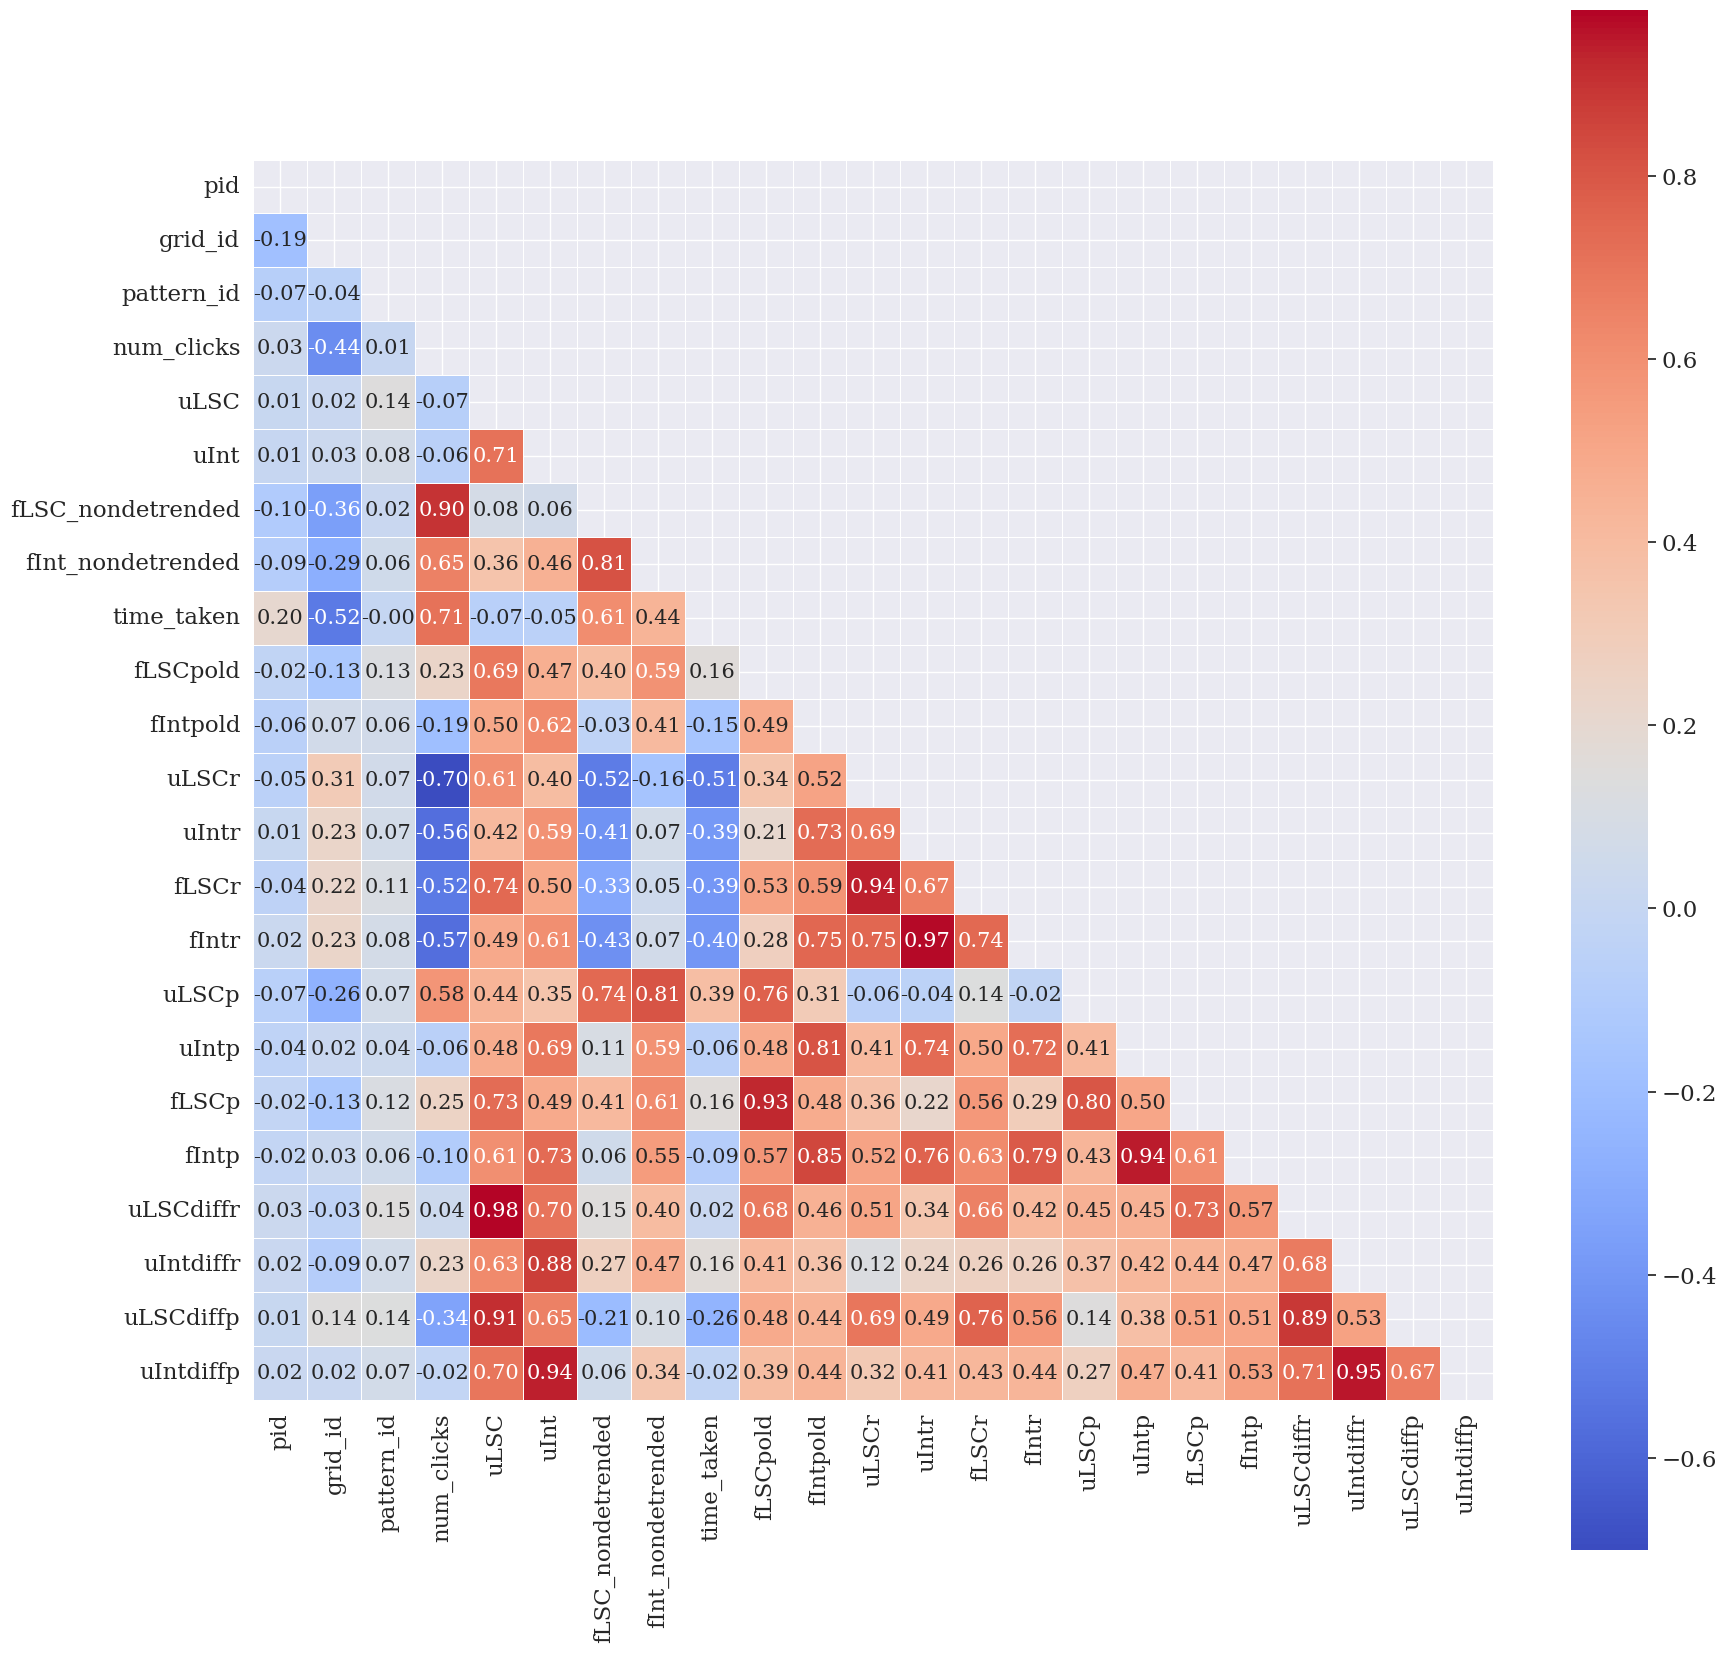

In [11]:
corr_matrix = grid_data.select_dtypes(include=[np.number]).corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 15}, fmt=".2f");

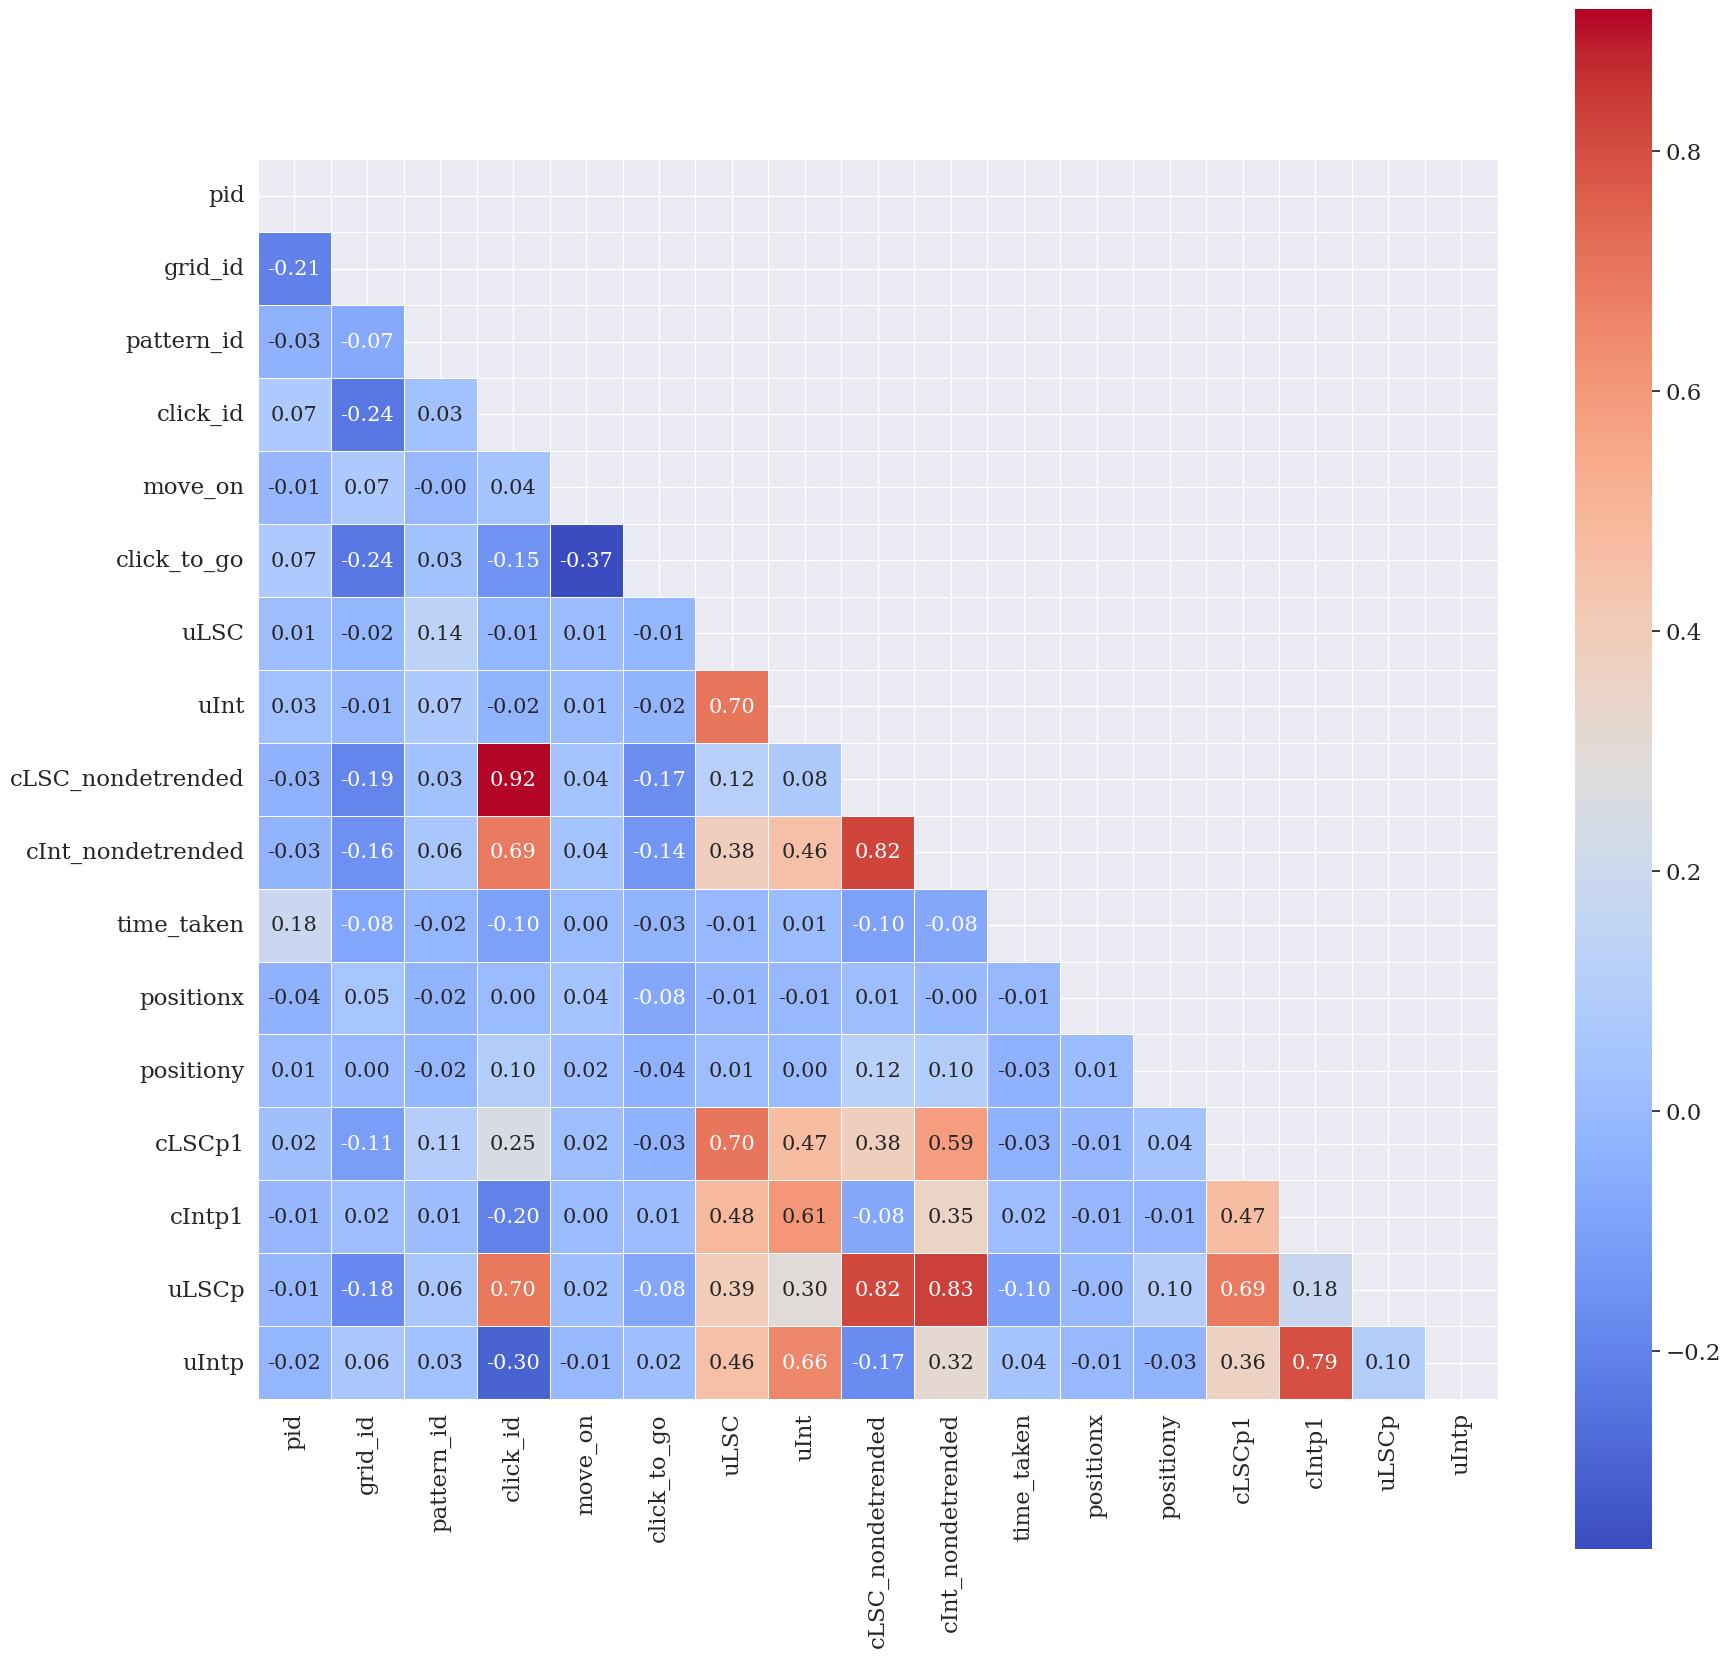

In [8]:
corr_matrix = click_data.select_dtypes(include=[np.number]).corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=.5, annot_kws={"size": 15}, fmt=".2f");

## Click time analysis

Percent outliers: 2.0472907237426505


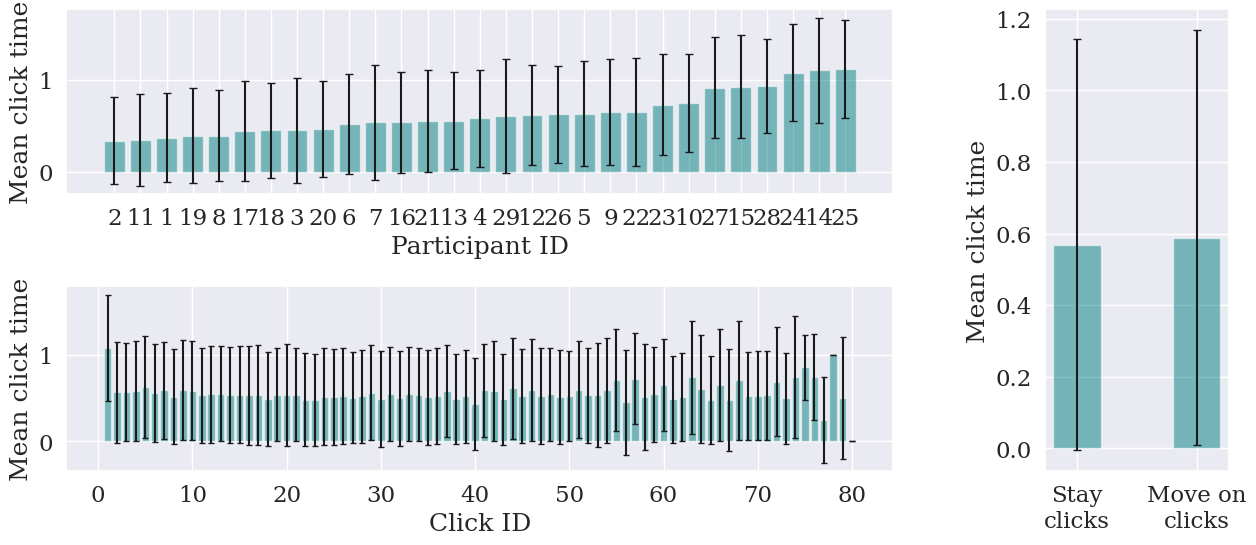

In [12]:
Q1 = click_data["time_taken"].quantile(0.25)
Q3 = click_data["time_taken"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

percent_outliers = len(click_data[click_data["time_taken"] > upper_bound]) / len(click_data) * 100
print("Percent outliers:", percent_outliers)
click_data_nooutliertimes = click_data[click_data["time_taken"] < upper_bound]

grouped_data_pid = click_data_nooutliertimes[["pid", "time_taken"]].groupby("pid").agg(['mean', 'std'])["time_taken"]
grouped_data_clickid = click_data_nooutliertimes[["click_id", "time_taken"]].groupby("click_id").agg(['mean', 'std'])["time_taken"].reset_index()
sorted_data = grouped_data_pid.sort_values("mean").reset_index()

# Plotting
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4.5, 1], height_ratios=[1, 1], wspace=0.3)

ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(
    list(map(str, sorted_data["pid"].values)),
    sorted_data["mean"].values,
    yerr=sorted_data["std"].values,
    capsize=3,
    color='teal',
    alpha=0.5
)
ax0.set_xlabel("Participant ID")
ax0.set_ylabel("Mean click time")

ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(
    grouped_data_clickid["click_id"],
    grouped_data_clickid["mean"].values,
    yerr=grouped_data_clickid["std"].values,
    capsize=2,
    color='teal',
    alpha=0.5
)
ax1.set_xlabel("Click ID")
ax1.set_ylabel("Mean click time")

ax2 = fig.add_subplot(gs[:, 1])
ax2.bar(["Stay\nclicks", "Move on\nclicks"], 
        [click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 0]["time_taken"].mean(), click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 1]["time_taken"].mean()], 
        yerr=[click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 0]["time_taken"].std(), click_data_nooutliertimes[click_data_nooutliertimes["move_on"] == 1]["time_taken"].std()],
        capsize=3,
        color='teal',
        width=0.4,
        alpha=0.5
    )
ax2.set_ylabel("Mean click time")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.1)

plt.tight_layout()

## Order of Grid Opening

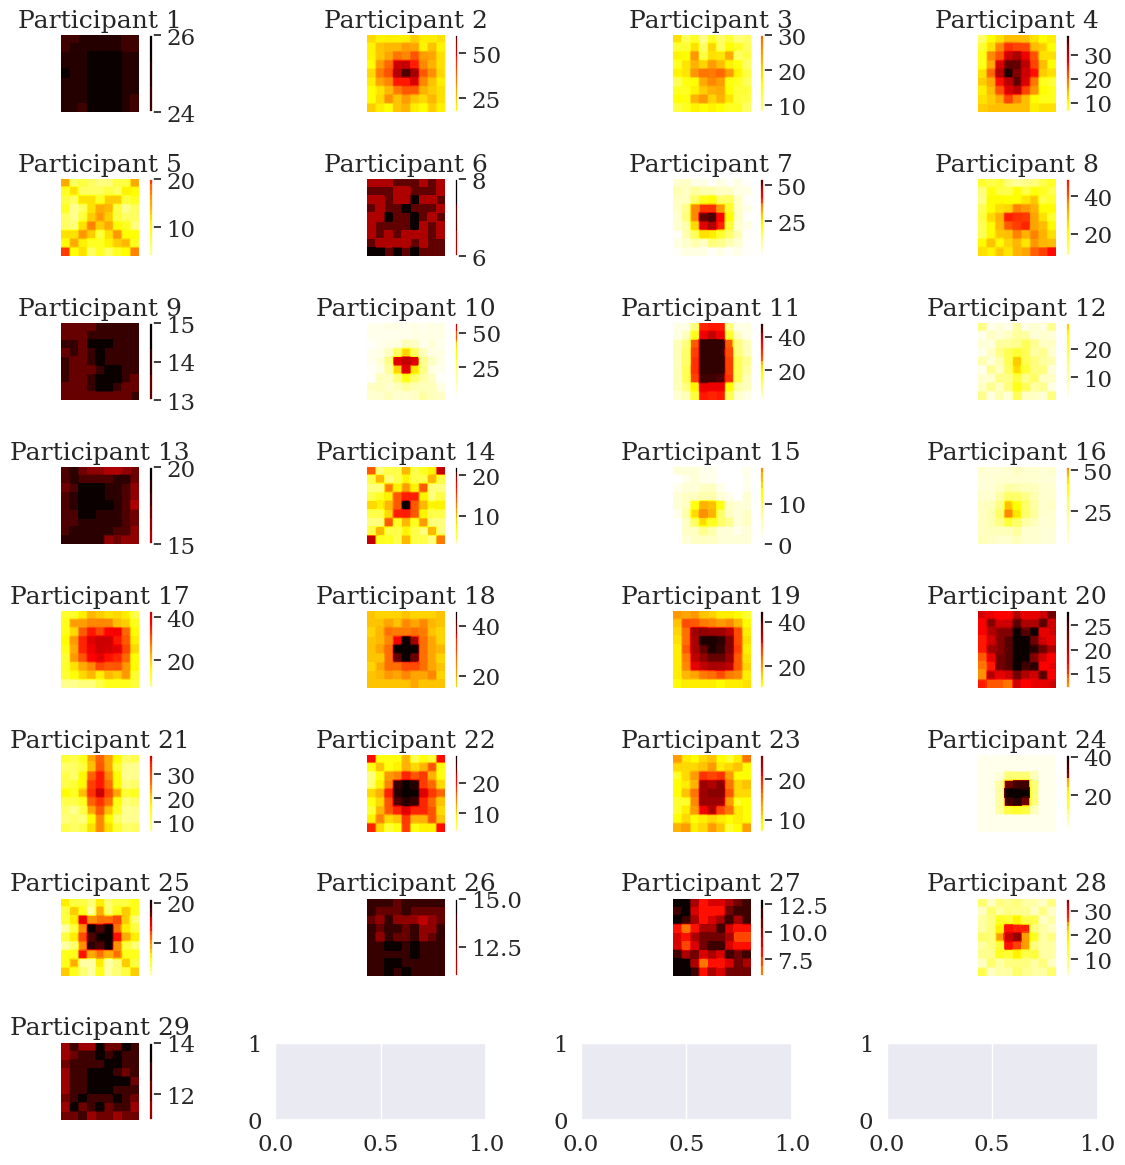

In [23]:
colmaptemp = matplotlib.cm.get_cmap('hot_r')
heatmap_colours = {}
for c in range(101):
    heatmap_colours[c] = colmaptemp(c * (1/100))
    
fig, axs = plt.subplots(8, 4, figsize=(12,12))
for sub in range(num_participants):
    cpx = click_data_all[click_data_all["pid"] == sub + 1]["positionx"].values
    cpy = click_data_all[click_data_all["pid"] == sub + 1]["positiony"].values
    heatmap = np.zeros((grid_size, grid_size))
    for pos in zip(cpx, cpy):
        if pos[0] % 3 == 0:
            xpos = [pos[0], pos[0] + 1, pos[0] + 2]
        elif pos[0] % 3 == 1:
            xpos = [pos[0] - 1, pos[0], pos[0] + 1]
        elif pos[0] % 3 == 2:
            xpos = [pos[0] - 2, pos[0] - 1, pos[0]]
        if pos[1] % 3 == 0:
            ypos = [pos[1], pos[1] + 1, pos[1] + 2]
        elif pos[1] % 3 == 1:
            ypos = [pos[1] - 1, pos[1], pos[1] + 1]
        elif pos[1] % 3 == 2:
            ypos = [pos[1] - 2, pos[1] - 1, pos[1]]

        for xind in xpos:
            for yind in ypos:
                heatmap[xind, yind] += 1
    colmap = matplotlib.colors.ListedColormap([heatmap_colours[int(i)] for i in np.unique(heatmap)*100//len(grid_data[grid_data["pid"] == sub + 1])  ])  
    axs[int(sub/4), sub%4].imshow(heatmap, cmap=colmap)
    axs[int(sub/4), sub%4].set_title('Participant ' + str(sub + 1))
    axs[int(sub/4), sub%4].axis('off')
    plt.colorbar(axs[int(sub/4), sub%4].imshow(heatmap, cmap=colmap), ax=axs[int(sub/4), sub%4])
    # plt.colorbar()
fig.tight_layout()

(-5.0, 154.0)

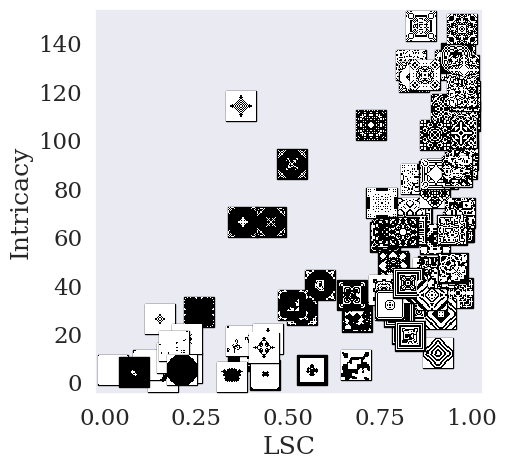

In [38]:
sns.set_style("dark")
plt.rc("font", family="serif")

def get_image(path):
    return OffsetImage(plt.imread(path),  zoom=0.02)  # Adjust zoom as per the image size

# Create the plot
fig, ax = plt.subplots(figsize=(5,5))

# Loop through the DataFrame to place images
for idx, row in pattern_stats.iterrows():
    if row['uInt'] > 150:
        continue
    image_path = os.path.join(f'../../patterns/grid-search/experiment/range{row["range"]}/', row['name'])  # Build the image path
    if os.path.exists(image_path):  # Ensure the file exists
        img = get_image(image_path)
        # ab = AnnotationBbox(img, (row['underlying_LSC'], row['underlying_intricacy']), frameon=False)
        ab = AnnotationBbox(img, (row['uLSC'], row['uInt']), 
                            frameon=True, 
                            bboxprops=dict(edgecolor='black', linewidth=1),
                            pad=0.001)
        ax.add_artist(ab)

# Set labels
ax.set_xlabel('LSC')
ax.set_ylabel('Intricacy')
ax.set_xlim(-0.025, 1.03)
ax.set_ylim(-5, 154)

plt.savefig("plots/LSC_by_intricacy.pdf", format='pdf', dpi=300, bbox_inches='tight');

In [ ]:
max(pd.read_csv("utils/grid_data.csv").groupby("Subject").agg(max)["grid_id"])

In [ ]:
for df in os.listdir("../../data/grid-search/"):
    if df[0:4] != "data":
        continue
    with open("../../data/grid-search/" + df) as f:
        d = json.load(f)
        print(df, d["trials"][0]["num_grids_visited"])

## People who revisited patterns

In [33]:
for pid, count in grid_data.groupby("pid").count()["grid_id"].items():
    if count > 98:
        print(f"PID {pid} visited {count} grids. Therefore revisited {count - 98} grids.")

PID 16 visited 120 grids. Therefore revisited 22 grids.
